[3.99643999e-02 1.77202479e+00 3.15010056e+03]
[array([1.15104497e+00, 3.38260219e-02, 1.04131579e-06]), 12.480079555148656]


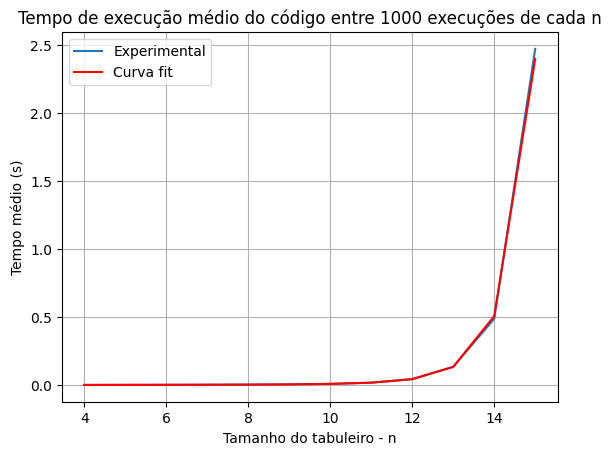

2.0201174407307514

In [54]:
import numpy as np
import matplotlib.pyplot as plt

with open('data_game.npy', 'rb') as f:
    means = np.load(f).tolist()
    stds = np.load(f).tolist()
    ns = np.load(f).tolist()

means_to_fit = np.array(means)
ns_to_fit = np.array(ns)

means_to_fit = np.log(means_to_fit)

A = np.array([ns_to_fit**2, ns_to_fit, np.ones(len(ns)), np.log(ns_to_fit)]).transpose()
coef = np.linalg.inv(A.transpose() @ A) @ A.transpose() @ means_to_fit.transpose()

y_fit = coef[0] * ns_to_fit**2 + coef[1] * ns_to_fit + coef[2] + np.log(ns_to_fit) * coef[3]
print(np.e ** (np.polyval(coef[0:3], np.array([15, 17, 20]))+coef[3]* np.log(np.array([15, 17, 20])))/(60))
print([np.e ** coef[0:3], coef[3]])

plt.figure()
plt.plot(ns, np.e**means_to_fit)
plt.grid(True)
plt.plot(ns, np.e**y_fit, 'r')
plt.xlabel('Tamanho do tabuleiro - n')
plt.ylabel('Tempo médio (s)')
plt.title('Tempo de execução médio do código entre 1000 execuções de cada n')
plt.legend(['Experimental', 'Curva fit'])
plt.savefig('eficiencia.png')
plt.show()
(1.151) ** 5

In [133]:
import numpy as np

class HeapMin(list):
    def __init_subclass__(cls) -> None:
        return super().__init_subclass__()
    
    def sift(self, i):
        esq = 2*i+1
        dire = 2*i+2
        maior = i
        if esq < self.__len__() and self[esq][0] < self[i][0]:
            maior = esq
        if dire < self.__len__() and self[dire][0] < self[maior][0]:
            maior = dire
        if maior != i:
            aux = self[i]
            self[i] = self[maior]
            self[maior] = aux
            self.sift(maior)

    def min(self):
        return self[0]
    
    def extract_min(self):
        if self.__len__() < 1:
            raise ValueError()
        else:
            maxi = self[0]
            if self.__len__() > 1:
                self[0] = self.pop()
                self.sift(0)
            else:
                self.pop()
            return maxi
        
    def modify(self, k, x):
        if k >= self.__len__() or k < 0:
            raise IndexError()
        else:
            self[k] = x
            while k > 0 and self[int(np.ceil(k / 2)-1)][0] > self[k][0]:
                aux = self[k]
                self[k] = self[int(np.ceil(k / 2)-1)]
                self[int(np.ceil(k / 2)-1)] = aux
                k = int(np.ceil(k / 2) - 1)
            self.sift(k)

    def insert(self, x):
        self.append(x)
        self.modify(self.__len__()-1, x)

    def find(self, x):
        for i in range(self.__len__()):
            if self[i][1] == x:
                return i
        return None
    
class HeapMax(object):
    # def __init_subclass__(cls) -> None:
    #     return super().__init_subclass__()
    def __init__(self, vector):
        self.heap = vector
    
    def sift(self, i):
        esq = 2*i+1
        dire = 2*i+2
        maior = i
        if esq < self.heap.__len__() and self.heap[esq][0] > self.heap[i][0]:
            maior = esq
        if dire < self.heap.__len__() and self.heap[dire][0] > self.heap[maior][0]:
            maior = dire
        if maior != i:
            aux = self.heap[i]
            self.heap[i] = self.heap[maior]
            self.heap[maior] = aux
            self.sift(maior)

    def max(self):
        return self.heap[0]
    
    def extract_max(self):
        if self.heap.__len__() < 1:
            raise ValueError()
        else:
            maxi = self.heap[0]
            if self.heap.__len__() > 1:
                self.heap[0] = self.heap.pop()
                self.sift(0)
            else:
                self.heap.pop()
            return maxi
        
    def modify(self, k, x):
        if k >= self.heap.__len__() or k < 0:
            raise IndexError()
        else:
            self.heap[k] = x
            while k > 0 and self.heap[int(np.ceil(k / 2)-1)][0] < self.heap[k][0]:
                aux = self.heap[k]
                self.heap[k] = self.heap[int(np.ceil(k / 2)-1)]
                self.heap[int(np.ceil(k / 2)-1)] = aux
                k = int(np.ceil(k / 2) - 1)
            self.sift(k)

    def insert(self, x):
        self.heap.append(x)
        self.modify(self.heap.__len__()-1, x)

    def find(self, x):
        for i in range(self.heap.__len__()):
            if self.heap[i][1] == x:
                return i
        return None

In [4]:
"""
Constants used in the code
"""

POSSIBLE_TENT = 1
TENT = 2
TREE = 3
EMPTY = 0
TIPS_ZEROED = -1

NUM_POSSIBLE_TENTS_TO_PUT_EMPTY = 4

FOUR_CONNECTED = [(-1,0), (1,0), (0,-1), (0,1)]
EIGHT_CONNECTED = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]

In [5]:
import numpy as np
import math
import random
import os
from pdf2image import convert_from_path
from PIL import Image
import matplotlib.pyplot as plt

class TentsGame(object):
    """
    Creates a tents game, where size is the size of rectangular field.

    trees_x and trees_y are the coordinates of the trees, starting at zero of the top left.

    tips_x and tips_y are the number of tents in each column and row respectively
    """

    # def __init__(self, size, trees_x, trees_y, tips_x, tips_y):
    #     self.size = size
    #     self.field = np.ones((size, size), dtype = int) * EMPTY
    #     for x, y in zip(trees_x, trees_y):
    #         self.field[y, x] = TREE

    #     self.tips_x = tips_x
    #     self.tips_y = tips_y

    def __init__(self, size = 6, seed = None, show_before_remove_tents = False, generate = True, trees_x=[], trees_y=[], tips_x=[], tips_y=[]):
        if generate:
            if seed != None:
                random.seed(seed)

            self.size = size
            self.number_of_trees = int(math.floor(size * size / 5))
            self.field = np.ones((size, size)) * EMPTY
            done = False
            while not done:
                try:
                    self._construct_put_tents()
                    done = True
                except:
                    done = False
            (self.tips_x, self.tips_y) = self._get_tents_positions()
            self.tips_x_copy, self.tips_y_copy = np.array(self.tips_x.copy()), np.array(self.tips_y.copy())
            done = False
            while not done:
                try:
                    self._construct_put_trees()
                    done = True
                except:
                    done = False
            if not show_before_remove_tents:
                self._construct_remove_tents()
        else:
            self.size = size
            self.field = np.ones((size, size), dtype = int) * EMPTY
            for x, y in zip(trees_x, trees_y):
                self.field[y, x] = TREE

            self.tips_x = tips_x
            self.tips_x_copy = np.array(tips_x.copy())
            self.tips_y = tips_y
            self.tips_y_copy = np.array(tips_y.copy())
            self.trees = []
            for i, j in zip(trees_y, trees_x):
                self.trees.append((i, j))

    def __repr__(self):
        field_repr = '   '
        for i in range(len(self.tips_x)):
            field_repr += ' ' + str(self.tips_x[i])
        field_repr += '\n   '
        for i in range(len(self.tips_x)):
            field_repr += '--'
        field_repr += '\n'

        for i in range(self.size):
            field_repr += str(self.tips_y[i]) + ' |'
            for j in range(self.size):
                if self.field[i, j] == TREE:
                    field_repr += ' ' + '\U00002663'
                elif self.field[i, j] == EMPTY:
                    field_repr += ' ' + '\U000025A1'
                elif self.field[i, j] == TENT:
                    field_repr += ' ' + '\U000025B2'
                elif self.field[i, j] == POSSIBLE_TENT:
                    field_repr += ' ' + '\U000025A0'
            field_repr += '\n'
        return field_repr
    
    def _construct_put_tents(self):
        positions = []
        for i in range(self.size):
            for j in range(self.size):
                positions.append((i, j))

        tents = []
        for k in range(self.number_of_trees):
            tents.append(random.sample(positions, 1)[0])
            positions.remove(tents[-1])
            for i in range(-1, 2):
                for j in range(-1, 2):
                    if tents[-1][0] + i >= 0 and tents[-1][0] + i < self.size:
                        if tents[-1][1] + j >= 0 and tents[-1][1] + j < self.size:
                            if i != 0 or j != 0:
                                try:
                                    positions.remove((tents[-1][0]+i, tents[-1][1]+j))
                                except:
                                    pass

        for tent in tents:
            self.field[tent[0], tent[1]] = TENT
        self.tents = tents

    def _get_tents_positions(self):
        tips_y = np.sum(self.field, axis=1) / TENT
        tips_x = np.sum(self.field, axis=0) / TENT

        return tips_x.astype(int).tolist(), tips_y.astype(int).tolist()

    def _construct_put_trees(self):
        possible_positions_to = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.trees = []
        for tent in self.tents:
            position_to = random.sample(possible_positions_to, 4)
            for i in range(4):
                if tent[0]+position_to[i][0] >= 0 and tent[0]+position_to[i][0] < self.size and tent[1]+position_to[i][1] >= 0 and tent[1]+position_to[i][1] < self.size:
                    if self.field[tent[0]+position_to[i][0], tent[1]+position_to[i][1]] != TREE:
                        self.field[tent[0]+position_to[i][0], tent[1]+position_to[i][1]] = TREE
                        self.trees.append((tent[0]+position_to[i][0], tent[1]+position_to[i][1]))
                        break
                    else:
                        continue
    
    def _construct_remove_tents(self):
        for tent in self.tents:
            self.field[tent[0], tent[1]] = EMPTY
        self.tents = []

    def show(self):
        fileTEX = open('pic.tex', 'w', encoding='UTF-8')
        fileTEX.write('\\documentclass{article}\n')
        fileTEX.write('\\usepackage{fontspec}\n')
        fileTEX.write('\\newfontfamily{\\NotoEmoji}{NotoColorEmoji.ttf}[Renderer=Harfbuzz]\n')
        # fileTEX.write('\\newfontfamily{\\SymbolaEmoji}{Symbola}\n')
        fileTEX.write('\\usepackage{tikz}\n')
        fileTEX.write('\\usetikzlibrary{positioning,calc,3d,}\n')
        fileTEX.write('\\usepackage{pgfplots}\n')
        fileTEX.write('\\begin{document}\n')
        fileTEX.write('\t\\resizebox{\\textwidth}{!}{\n')
        fileTEX.write('\t\t\\begin{tikzpicture}\n')
        # for i in range(self.size+1):
        #     fileTEX.write(f'\t\t\t\\draw[thick] (0,{i})--++({self.size},0);\n')
        #     fileTEX.write(f'\t\t\t\\draw[thick] ({i},0)--++(0,{self.size});\n')
        for i in range(self.size):
            for j in range(self.size):
                if self.field[i, j] == EMPTY:
                    fileTEX.write(f'\t\t\t\\node[draw=black,thick,fill=brown!50, anchor=north west, minimum size = 1cm] (a{i}{j}) at ({j},{self.size-i})'+' {};\n')
                elif self.field[i, j] == TREE:
                    fileTEX.write(f"\t\t\t\\node[draw=black,thick,fill=green!50, anchor=north west, minimum size = 1cm] (a{i}{j}) at ({j},{self.size-i})"+' {\\NotoEmoji\\symbol{"1F333}};\n')
                elif self.field[i, j] == TENT:
                    fileTEX.write(f'\t\t\t\\node[draw=black,thick,fill=green!50, anchor=north west, minimum size = 1cm] (a{i}{j}) at ({j},{self.size-i})'+' {\\NotoEmoji\\symbol{"26FA}};\n')
                elif self.field[i, j] == POSSIBLE_TENT:
                    fileTEX.write(f'\t\t\t\\node[draw=black,thick,fill=black!50, anchor=north west, minimum size = 1cm] (a{i}{j}) at ({j},{self.size-i})'+' {};\n')
        for i, x in enumerate(self.tips_x):
            fileTEX.write(f'\t\t\t\\node (x{i}) at ({i+0.5},{self.size+0.5})'+' {\\textbf{'+f'{x}'+'}};\n')
        for j, y in enumerate(self.tips_y):
            fileTEX.write(f'\t\t\t\\node (y{j}) at ({-0.5},{self.size-j-0.5})'+' {\\textbf{'+f'{y}'+'}};\n')
        
        fileTEX.write('\t\t\\end{tikzpicture}\n')
        fileTEX.write('\t}\n')
        fileTEX.write('\\end{document}')

        fileTEX.close()

        os.system('lualatex.exe -synctex=1 -interaction=nonstopmode "pic".tex > NUL 2>&1')

        images = convert_from_path('pic.pdf')
        for image in images:
            image.save('pic.png', 'PNG')

        image_original = np.asarray(Image.open('pic.png'))
        plt.imshow(image_original[300:1300, 350:1450, :])
        plt.grid(False)
        plt.axis('off')
        plt.show()
        os.system('del pic.*')

In [134]:
from math import inf
counter = 0

class TentsGameSolver(object):
    def __init__(self, tents_game):
        self.tents_game = tents_game
        self.field = tents_game.field
        self.size = tents_game.size
        self.tips_x_copy = tents_game.tips_x_copy
        self.tips_y_copy = tents_game.tips_y_copy
        self.tips_x = tents_game.tips_x
        self.tips_y = tents_game.tips_y
        self.trees = tents_game.trees
        self.trees_possibilities = HeapMin([]) # heap to use in solving
        self.possible_tents = HeapMax([])
        self.acabou_pela_regra = False
        self.verified_tips_equal_0 = False
        self.verified_possible_tents_equal_1 = False
        self.verified_tips_equal_possible_tents = False
        self.is_wrong = False
        self.state_queue = [] # To store the previous state of solving: field, tips_copy

    def init(self):
        self.start()
        self.verifies_tips_equal_0()
        self.verifies_possible_tents_equal_1()
        while self.verified_possible_tents_equal_1:
            self.verifies_tips_equal_0()
            self.verifies_possible_tents_equal_1()

#         self.verifies_tips_equal_possible_tents()
#         self.verifies_tips_equal_0()
#         self.verifies_tips_equal_possible_tents()
#         while self.verified_tips_equal_possible_tents or self.verified_tips_equal_0:
#             self.verifies_tips_equal_0()
#             self.verifies_tips_equal_possible_tents()
        # print('Finished initial state')
#         self.heuristic()
    
    def is_valid_coordinate(self, i, j):
        if i >= 0 and i < self.size and j >= 0 and j < self.size:
            return True
        return False 

    def update_minimum_heap(self, i, j):
        for ii, jj in FOUR_CONNECTED:
            coord_i = i + ii
            coord_j = j + jj
            if self.is_valid_coordinate(coord_i, coord_j) and self.field[coord_i, coord_j] == TREE:
                index = self.trees_possibilities.find((coord_i, coord_j))
                if index != None:
                    self.trees_possibilities.modify(index, (self.trees_possibilities[index][0]-1, self.trees_possibilities[index][1]))

    def update_maximum_heap(self, i, j):
        index = self.possible_tents.find((i, j))
        self.possible_tents.modify(index, (inf, self.possible_tents.heap[index][1]))
        self.possible_tents.extract_max()
        for ii, jj in EIGHT_CONNECTED:
            coord_i = i + ii
            coord_j = j + jj
            if self.is_valid_coordinate(coord_i, coord_j) and self.field[coord_i, coord_j] == POSSIBLE_TENT:
                index = self.possible_tents.find((coord_i, coord_j))
                self.possible_tents.modify(index, (self.possible_tents.heap[index][0]-1, self.possible_tents.heap[index][1]))

    def put_tent(self, tree, know_what_tree=True, tent=(None, None)):
        if know_what_tree:
            for i, j in FOUR_CONNECTED:
                coord_i = tree[0] + i
                coord_j = tree[1] + j
                if self.is_valid_coordinate(coord_i, coord_j):
                    if self.field[coord_i, coord_j] == POSSIBLE_TENT:
                        self.field[coord_i, coord_j] = TENT
                        self.update_8_connected((coord_i, coord_j))
                        self.tips_x_copy[coord_j] -= 1
                        self.tips_y_copy[coord_i] -= 1
        else:
            if self.field[tent[0], tent[1]] == EMPTY:
                self.is_wrong = True
            else:
                self.field[tent[0], tent[1]] = TENT
                self.update_8_connected(tent)
                self.tips_x_copy[tent[1]] -= 1
                self.tips_y_copy[tent[0]] -= 1

    def update_8_connected(self, tent):
        self.update_maximum_heap(tent[0], tent[1])
        for i, j in EIGHT_CONNECTED:
            coord_i = tent[0] + i
            coord_j = tent[1] + j
            if self.is_valid_coordinate(coord_i, coord_j):
                if self.field[coord_i, coord_j] == POSSIBLE_TENT:
                    self.field[coord_i, coord_j] = EMPTY
                    self.update_minimum_heap(coord_i, coord_j)
                    self.update_maximum_heap(coord_i, coord_j)

    def save_state(self, possible_tent, was_tent):
        self.state_queue.append((
            self.field.copy(),
            self.tips_x_copy.copy(),
            self.tips_y_copy.copy(),
            HeapMax(self.possible_tents.heap.copy()),
            self.verified_tips_equal_0,
            self.verified_possible_tents_equal_1,
            self.verified_tips_equal_possible_tents,
            self.is_wrong,
            possible_tent,
            was_tent
        ))

    def return_last_state(self):
        (
            self.tents_game.field,
            self.tents_game.tips_x_copy,
            self.tents_game.tips_y_copy,
            self.possible_tents,
            self.verified_tips_equal_0,
            self.verified_possible_tents_equal_1,
            self.verified_tips_equal_possible_tents,
            self.is_wrong,
            possible_tent,
            was_tent
        ) = self.state_queue.pop()
        self.field = self.tents_game.field
        self.tips_x_copy = self.tents_game.tips_x_copy
        self.tips_y_copy = self.tents_game.tips_y_copy
        return possible_tent, was_tent

    def check_is_wrong(self, finished=False):
        if not self.is_wrong:
            # Check if a tree has no tent
            for tree in self.trees:
                self.is_wrong = True
                for i, j in FOUR_CONNECTED:
                    coord_i = tree[0] + i
                    coord_j = tree[1] + j
                    if self.is_valid_coordinate(coord_i, coord_j):
                        if self.field[coord_i, coord_j] == TENT or self.field[coord_i, coord_j] == POSSIBLE_TENT:
                            self.is_wrong = False
                            break
                if self.is_wrong:
                    break
            if len(self.possible_tents.heap) == 0:
                # Check if number of tents is less than tips when is over
                for j, tip_x in enumerate(self.tips_x):
                    if tip_x > len(np.where(self.field[:, j] == TENT)[0]):
                        self.is_wrong = True
                        break
                for i, tip_y in enumerate(self.tips_y):
                    if tip_y > len(np.where(self.field[i, :] == TENT)[0]):
                        self.is_wrong = True
                        break
            else:
                # Check if number of tents is greater than tips while is not over
                for j, tip_x in enumerate(self.tips_x):
                    if tip_x < len(np.where(self.field[:, j] == TENT)[0]):
                        self.is_wrong = True
                        break
                for i, tip_y in enumerate(self.tips_y):
                    if tip_y < len(np.where(self.field[i, :] == TENT)[0]):
                        self.is_wrong = True
                        break
        
    def start(self):
        possible_tents = []
        for tree in self.trees:
            num_possible_tents = 0
            for i, j in FOUR_CONNECTED:
                coord_i = tree[0] + i
                coord_j = tree[1] + j
                if self.is_valid_coordinate(coord_i, coord_j):
                    if self.field[coord_i, coord_j] == EMPTY or self.field[coord_i, coord_j] == POSSIBLE_TENT:
                        if self.field[coord_i, coord_j] != POSSIBLE_TENT:
                            possible_tents.append((coord_i, coord_j))
                        self.field[coord_i, coord_j] = POSSIBLE_TENT
                        num_possible_tents += 1
            self.trees_possibilities.insert((num_possible_tents, tree))
        for possible_tent in possible_tents:
            num_possible_tents = 0
            for i, j in EIGHT_CONNECTED:
                coord_i = possible_tent[0] + i
                coord_j = possible_tent[1] + j
                if self.is_valid_coordinate(coord_i, coord_j):
                    if self.field[coord_i, coord_j] == POSSIBLE_TENT:
                        num_possible_tents += 1
            self.possible_tents.insert((num_possible_tents, possible_tent))

    def verifies_tips_equal_0(self):
        self.verified_tips_equal_0 = False
        if not self.is_wrong:
            for j in np.where(self.tips_x_copy == 0)[0]:
                self.verified_tips_equal_0 = True
                self.tips_x_copy[j] = TIPS_ZEROED
                for i in np.where(self.field[:, j] == POSSIBLE_TENT)[0]:
                    self.field[i, j] = EMPTY
                    self.update_minimum_heap(i, j)
                    self.update_maximum_heap(i, j)
            for i in np.where(self.tips_y_copy == 0)[0]:
                self.verified_tips_equal_0 = True
                self.tips_y_copy[i] = TIPS_ZEROED
                for j in np.where(self.field[i, :] == POSSIBLE_TENT)[0]:
                    self.field[i, j] = EMPTY
                    self.update_minimum_heap(i, j)
                    self.update_maximum_heap(i, j)

    def verifies_possible_tents_equal_1(self):
        self.verified_possible_tents_equal_1 = False
        while len(self.trees_possibilities) > 0 and self.trees_possibilities[0][0] == 1:
            self.verified_possible_tents_equal_1 = True
            tree = self.trees_possibilities[0][1]
            self.trees_possibilities.extract_min()
            self.put_tent(tree)

    def verifies_tips_equal_possible_tents(self):
        self.verified_tips_equal_possible_tents = False
        if not self.is_wrong:
            for i in range(self.size):
                aux = np.where(self.field[i, :] == POSSIBLE_TENT)[0]
                if self.tips_y_copy[i] == len(aux):
                    self.verified_tips_equal_possible_tents = True
                    for j in aux:
                        self.put_tent((None, None), know_what_tree=False, tent=(i, j))
            for j in range(self.size):
                aux = np.where(self.field[:, j] == POSSIBLE_TENT)[0]
                if self.tips_x_copy[j] == len(aux):
                    self.verified_tips_equal_possible_tents = True
                    for i in aux:
                        self.put_tent((None, None), know_what_tree=False, tent=(i, j))
    
    def heuristic(self):
        while len(self.possible_tents.heap) > 0 or self.is_wrong:
            if not self.is_wrong:
                if self.possible_tents.heap[0][0] >= NUM_POSSIBLE_TENTS_TO_PUT_EMPTY:
                    possible_tent = self.possible_tents.heap[0][1]
                    self.save_state(possible_tent, was_tent=False)
                    self.field[possible_tent[0], possible_tent[1]] = EMPTY
                    self.update_maximum_heap(possible_tent[0], possible_tent[1])
                else:
                    possible_tent = self.possible_tents.heap[0][1]
                    self.save_state(possible_tent, was_tent=True)
                    self.put_tent((None, None), know_what_tree=False, tent=possible_tent)
                
                self.verifies_tips_equal_0()
                self.verifies_tips_equal_possible_tents()
                self.check_is_wrong()
                while self.verified_tips_equal_0 or self.verified_tips_equal_possible_tents:
                    self.verifies_tips_equal_0()
                    self.verifies_tips_equal_possible_tents()
                    self.check_is_wrong()
                    if self.is_wrong:
                        break
            else:
                possible_tent, was_tent = self.return_last_state()
                if was_tent:
                    self.field[possible_tent[0], possible_tent[1]] = EMPTY
                    self.update_maximum_heap(possible_tent[0], possible_tent[1])
                else:
                    self.put_tent((None, None), know_what_tree=False, tent=possible_tent)

                self.verifies_tips_equal_0()
                self.verifies_tips_equal_possible_tents()
                self.check_is_wrong()
                while self.verified_tips_equal_0 or self.verified_tips_equal_possible_tents:
                    self.verifies_tips_equal_0()
                    self.verifies_tips_equal_possible_tents()
                    self.check_is_wrong()
                    if self.is_wrong:
                        break
        else:
            # print('Finished heuristic')
            pass

In [135]:
%load_ext line_profiler

tents_game = TentsGame(6, seed=36)
tents_game_solution = TentsGameSolver(tents_game)
tents_game_solution.init()
print(tents_game_solution.possible_tents.heap)

%lprun -f tents_game_solution.possible_tents.find tents_game_solution.possible_tents.find((2,3))

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
[(0, (5, 3)), (0, (5, 5)), (0, (3, 3)), (0, (3, 5))]


In [44]:
test = np.zeros((100,100))
%timeit np.where(test[1, :] == 50)[0]


2.2 µs ± 19.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [45]:
%timeit a=(test[1,:]==50)

1.38 µs ± 3.83 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [78]:
a = int(a for a in range(1000) if a == 500)
print(a)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'generator'